In [1]:
from oclock import Timer, loop, interactiveloop
import time, random, threading

# Constant-duration loops

## Using the `Timer.checkpt()` method

The following code executes a print statement every 2 seconds and stops when the elapsed time of the loop exceeds 10 seconds.

In [2]:
timer = Timer(interval=2)
while timer.elapsed_time < 11:
    print("Elapsed time: {:.3f}".format(timer.elapsed_time))
    timer.checkpt()

Elapsed time: 0.000
Elapsed time: 2.000
Elapsed time: 4.000
Elapsed time: 6.001
Elapsed time: 8.002
Elapsed time: 10.002


## Using the `@loop` decorator

The following code does the same thing as the code above. In this simple situation, using the decorator is slightly more verbose.

In [3]:
timer = Timer(interval=2)
@loop(timer)
def my_function():
    """Example function to be repeated periodically"""
    print("Elapsed time: {:.3f}".format(timer.elapsed_time))
    if timer.elapsed_time > 10:
        timer.stop()
my_function()

Elapsed time: 2.000
Elapsed time: 4.001
Elapsed time: 6.001
Elapsed time: 8.001
Elapsed time: 10.002


# Interactive, cancellable loops

## Using the `@interactiveloop` decorator

In this case the timer is internal to the loop and cannot be accessed programatically, but a command line interface allows the user to interact dynamically with the Timer (e.g. change time interval, pause, reset etc.)

In [4]:
@interactiveloop(interval=2)
def interactive_function():
    """Example function to be repeated periodically"""
    print("This is a random number: {:.3f}".format(random.random()))
interactive_function()

-----------------------------------------------------------------
Timer Command-Line-Interface. Possible inputs:
- any number (int/float): change timer interval to that new value
- 'p' or 'pause': pause timer
- 'r' or 'resume': resume timer
- 'R' or 'reset': reset timer
- 't' or 'time': print timing (interval, elapsed time, etc.) info
- 'q', 'Q', 'quit' or 'stop': stop timer and exit
-----------------------------------------------------------------
This is a random number: 0.598

This is a random number: 0.457
This is a random number: 0.549
This is a random number: 0.655
--- Timer Paused
This is a random number: 0.596
--- Timer Resumed
This is a random number: 0.737
This is a random number: 0.868
This is a random number: 0.116
--- Timer Stopped
--- Loop Exited


## Using `Timer` methods and threading

To give an idea how to implement an interactive timer similar to the `@interactiveloop` decorator, here is a minimal example:

- Define the command line interface (CLI) to interact with the timer:

In [5]:
def user_input(timer):
    """Command line input to interact with a timer object."""
    print('Input command or press enter to exit\n')
    while not timer.is_stopped:
        a = input()
        try:
            dt = float(a)
        except ValueError:
            if a == 'pause':
                timer.pause()
            elif a == 'resume':
                timer.resume()
            elif a == 'reset':
                timer.reset()
            else:
                timer.stop()
        else:
            timer.interval = dt


- Run the CLI and the timer concurrently using a thread:

In [6]:
timer = Timer()
threading.Thread(target=user_input, args=(timer,)).start()
while not timer.is_stopped:
    print("This is a random number: {:.3f}".format(random.random()))
    timer.checkpt()

Input command or press enter to exit
This is a random number: 0.119

This is a random number: 0.862
This is a random number: 0.545
This is a random number: 0.995
This is a random number: 0.517
This is a random number: 0.055


# Change timer interval in real time

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def test_interval_change(immediate=True, precise=False):
    """Note: takes approximately 10 seconds to run"""
    
    print(f'Test started (immediate {immediate}, precise {precise})')

    timer1 = Timer(interval=0.1, precise=precise)
    timer2 = Timer(interval=0.07, precise=precise)
    tmax = 10

    def change_interval():
        targets = 2, 4, 7, 10, 15
        i = 0
        while timer2.elapsed_time <= tmax:
            if timer2.elapsed_time >= targets[i]:
                new_interval = timer1.interval + 0.1
                timer1.set_interval(new_interval, immediate=immediate)
                i += 1
                print('Interval change number', i, 'to dt =', timer1.interval)
            timer2.checkpt()


    def get_times():
        times = []
        timer1.reset()
        while timer1.elapsed_time <= tmax:
            times.append(time.perf_counter())
            timer1.checkpt()
        return times


    threading.Thread(target=change_interval).start()
    times = get_times()
    
    dt = np.diff(times)
    fig, ax = plt.subplots()
    ax.plot(dt, '-ok')
    ax.set_xlabel('timer iteration')
    ax.set_ylabel(r'$\Delta t$ (s)')
    ax.grid()

## Immediately cancellable timer

Test started (immediate True, precise False)
Interval change number 1 to dt = 0.2
Interval change number 2 to dt = 0.30000000000000004
Interval change number 3 to dt = 0.4


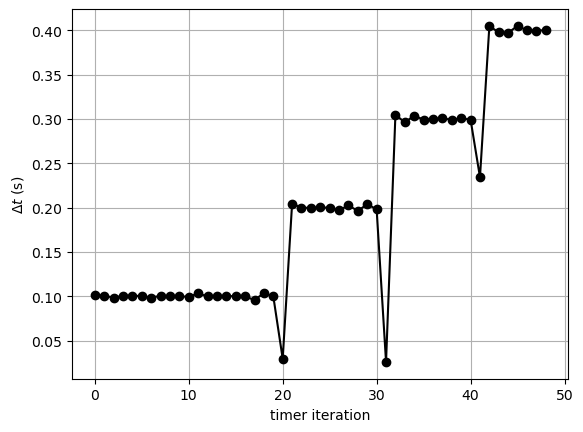

In [4]:
test_interval_change(immediate=True)

Note in the graph above the smaller intervals every time the timer interval is changed. This is because with `oclock.Timer` the time interval changes are effective immediately by default. If this is a problem, it is possible to use the `immediate=True` option in `Timer.set_interval()`:

Test started (immediate False, precise False)
Interval change number 1 to dt = 0.2
Interval change number 2 to dt = 0.30000000000000004
Interval change number 3 to dt = 0.4


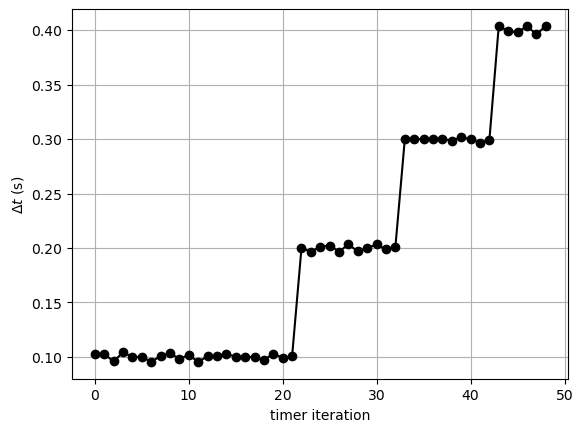

In [5]:
test_interval_change(immediate=False)

Finally, note that loops can be more precise when using the `precise=True` option of the timer:

Test started (immediate False, precise True)
Interval change number 1 to dt = 0.2
Interval change number 2 to dt = 0.30000000000000004
Interval change number 3 to dt = 0.4


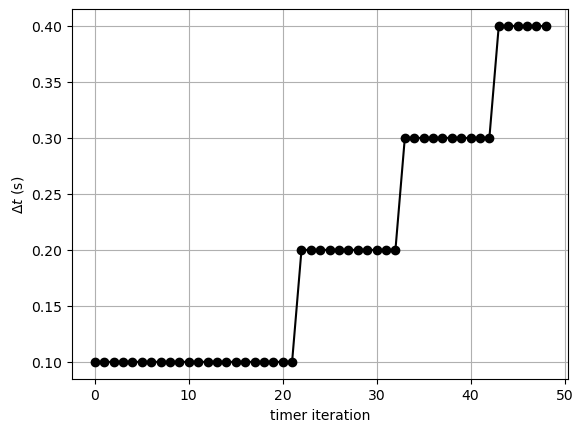

In [6]:
test_interval_change(immediate=False, precise=True)